In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import ast
import json
from collections import Counter
import datetime
import seaborn as sns
from tqdm import tqdm
import functions
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn.metrics as metric

In [2]:
cleaned_df = pd.read_csv('/content/drive/MyDrive/Capstone/philly_cleaned_data.csv')
print(cleaned_df.columns)
print(cleaned_df.shape)

Index(['review_id', 'user_id', 'business_id', 'stars_review', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars_business',
       'review_count', 'is_open', 'attributes', 'categories', 'tip_text',
       'tip_count', 'checkin_dates', 'checkin_count', 'name_user',
       'review_count_user', 'yelping_since', 'useful_user', 'funny_user',
       'cool_user', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos', 'cuisines', 'venue_type', 'food_type',
       'diet_features'],
      dtype='object')
(485423, 48)


In [3]:
cleaned_df['review_id'].nunique()

485423

In [4]:
# Picking columns relevant for demand forecast i.e. check-in data and business level attributes
demand_df0 = cleaned_df[['business_id','date','address','postal_code','latitude','longitude','stars_business','review_count','is_open','categories','tip_count','checkin_dates','cuisines','venue_type','food_type','diet_features']]
demand_df0['review_month'] = pd.to_datetime(demand_df0['date']).dt.to_period('M')
demand_df0.head(3)

/tmp/ipython-input-140074405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_df0['review_month'] = pd.to_datetime(demand_df0['date']).dt.to_period('M')


,business_id,date,address,postal_code,latitude,longitude,stars_business,review_count,is_open,categories,tip_count,checkin_dates,cuisines,venue_type,food_type,diet_features,review_month
0,kxX2SOes4o-D3ZQBkiMRfA,2015-01-04 00:01:03,2481 Grant Ave,19114.0,40.079848,-75.025080,4.0,181,1,"Halal, Pakistani, Restaurants, Indian",29.0,"2011-04-21 22:41:07, 2011-04-26 20:59:22, 2011...","['pakistani', 'indian']",['restaurant'],[],['halal'],2015-01
1,04UD14gamNjLY0IDYVhHJg,2015-09-23 23:10:31,795 S 3rd St,19147.0,39.938013,-75.148131,4.0,273,0,"Mediterranean, Restaurants, Seafood, Greek",28.0,"2010-03-27 22:04:48, 2010-07-13 00:09:00, 2010...","['mediterranean', 'greek']",['restaurant'],['seafood'],[],2015-09
2,RZtGWDLCAtuipwaZ-UfjmQ,2009-10-14 19:57:14,615 Chestnut St,19106.0,39.949529,-75.152139,3.5,367,0,"Pizza, Restaurants, Italian, Salad",50.0,"2010-02-08 17:03:02, 2010-06-22 18:08:57, 2010...",['italian'],['restaurant'],"['pizza', 'salad']",[],2009-10


In [5]:
# Creating demand across review months
review_demand = demand_df0.groupby(['business_id', 'review_month']).size().reset_index(name='review_count')

In [6]:
demand_df0.drop('date', axis=1, inplace=True)
demand_df0.drop_duplicates(inplace=True)

/tmp/ipython-input-3589231201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_df0.drop('date', axis=1, inplace=True)
/tmp/ipython-input-3589231201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_df0.drop_duplicates(inplace=True)


In [7]:
# Creating demand across check-in months
print("Processing check-in dates...")

# Filter valid checkins first
valid_mask = (demand_df0['checkin_dates'].notna() &
              (demand_df0['checkin_dates'] != '[]') &
              (demand_df0['checkin_dates'] != ''))

valid_checkins = demand_df0[valid_mask].copy()
print(f"Valid checkin rows: {len(valid_checkins)}")

chunk_size = 20000
all_checkin_demands = []

for i in tqdm(range(0, len(valid_checkins), chunk_size), desc="Processing chunks"):
    chunk = valid_checkins.iloc[i:i+chunk_size].copy()

    # Split and explode this chunk
    chunk['checkin_list'] = chunk['checkin_dates'].str.split(', ')
    exploded_chunk = chunk[['business_id', 'checkin_list']].explode('checkin_list')

    # Convert to months (vectorized)
    exploded_chunk['month'] = pd.to_datetime(exploded_chunk['checkin_list'], errors='coerce').dt.to_period('M')
    exploded_chunk = exploded_chunk[exploded_chunk['month'].notna()]

    # Aggregate this chunk
    chunk_demand = exploded_chunk.groupby(['business_id', 'month']).size().reset_index(name='checkin_count')
    all_checkin_demands.append(chunk_demand)

    # Clean up
    del chunk, exploded_chunk, chunk_demand

# Combine and final aggregation
print("Combining all chunks...")
checkin_demand = pd.concat(all_checkin_demands, ignore_index=True)
checkin_demand = checkin_demand.groupby(['business_id', 'month']).agg({'checkin_count': 'sum'}).reset_index()

print(f"Checkin demand shape: {checkin_demand.shape}")
print(checkin_demand.head())

Processing check-in dates...
Valid checkin rows: 145869


Processing chunks: 100%|██████████| 8/8 [01:37<00:00, 12.17s/it]

Combining all chunks...
Checkin demand shape: (135408, 3)
              business_id    month  checkin_count
0  -0M0b-XhtFagyLmsBtOe8w  2012-02             52
1  -0M0b-XhtFagyLmsBtOe8w  2012-03             26
2  -0M0b-XhtFagyLmsBtOe8w  2012-04             13
3  -0M0b-XhtFagyLmsBtOe8w  2012-05             13
4  -0M0b-XhtFagyLmsBtOe8w  2012-06             13


In [11]:
# Creating final monthly demand table
review_demand.rename(columns={'review_month': 'month'}, inplace=True)

review_demand['month'] = review_demand['month'].astype(str)
checkin_demand['month'] = checkin_demand['month'].astype(str)

monthly_demand = pd.merge(
    review_demand,
    checkin_demand,
    on=['business_id', 'month'],
    how='outer'
).fillna(0)

monthly_demand['demand'] = monthly_demand['review_count'] + monthly_demand['checkin_count']
monthly_demand['month'] = pd.to_datetime(monthly_demand['month'])

In [35]:
drop_cols = ['checkin_dates','review_month']
business_attr = demand_df0.drop(drop_cols,axis = 1)
business_attr.drop_duplicates(inplace=True)
business_attr.shape

(2960, 14)

In [48]:
import functions
import importlib
importlib.reload(functions)
multilabel_cols = ['categories', 'cuisines', 'venue_type', 'food_type', 'diet_features']

for col in multilabel_cols:
    print(f"\nEncoding {col}...")
    business_attr = functions.encode_multilabel_field(business_attr, col)


Encoding categories...
categories: 288 unique values found

Encoding cuisines...
cuisines: 18 unique values found

Encoding venue_type...
venue_type: 16 unique values found

Encoding food_type...
food_type: 24 unique values found

Encoding diet_features...
diet_features: 6 unique values found


In [14]:
date_range = pd.date_range(
    start=pd.to_datetime(monthly_demand['month']).min(),
    end=pd.to_datetime(monthly_demand['month']).max(),
    freq='MS'  # Month Start frequency
)

# For each business, create complete month range
complete_demand = []
for business in monthly_demand['business_id'].unique():
    business_data = monthly_demand[monthly_demand['business_id'] == business].copy()

    complete_dates = pd.DataFrame({
        'business_id': business,
        'month': date_range
    })
    complete_dates['month'] = pd.to_datetime(complete_dates['month'])
    business_data['month'] = pd.to_datetime(business_data['month'])

    merged = complete_dates.merge(
        business_data[['month', 'demand']],
        on='month',
        how='left'
    )
    merged['demand'] = merged['demand'].fillna(0)
    complete_demand.append(merged)

final_demand = pd.concat(complete_demand, ignore_index=True)

In [15]:
# Getting business attributes against demand dataset
forecast_df = final_demand.merge(
    business_attr,
    on='business_id',
    how='left'
)
forecast_df['review_count']=forecast_df['review_count']+forecast_df['tip_count']
forecast_df.drop('tip_count',axis=1,inplace=True)

In [50]:
# Apply variance filtering
forecast_df, low_variance_report = functions.remove_low_variance_features(
    forecast_df,
    threshold=0.90,
    exclude_cols=['business_id', 'month', 'demand']
)

print(f"\nFinal shape after variance filtering: {forecast_df.shape}")

No low-variance features found with threshold 0.9

Final shape after variance filtering: (603840, 25)


In [17]:
# Ensure month is datetime
forecast_df['month'] = pd.to_datetime(forecast_df['month'])

# Create splits, making post-COVID as out-of-time dataset
train_df = forecast_df[forecast_df['month'] <= '2017-12-31'].copy()
test_df = forecast_df[(forecast_df['month'] >= '2018-01-01') & (forecast_df['month'] <= '2020-02-29')].copy()
oot_df = forecast_df[forecast_df['month'] >= '2020-03-01'].copy()

Analyzing correlations for 22 numeric features
Correlation matrix shape: (22, 22)


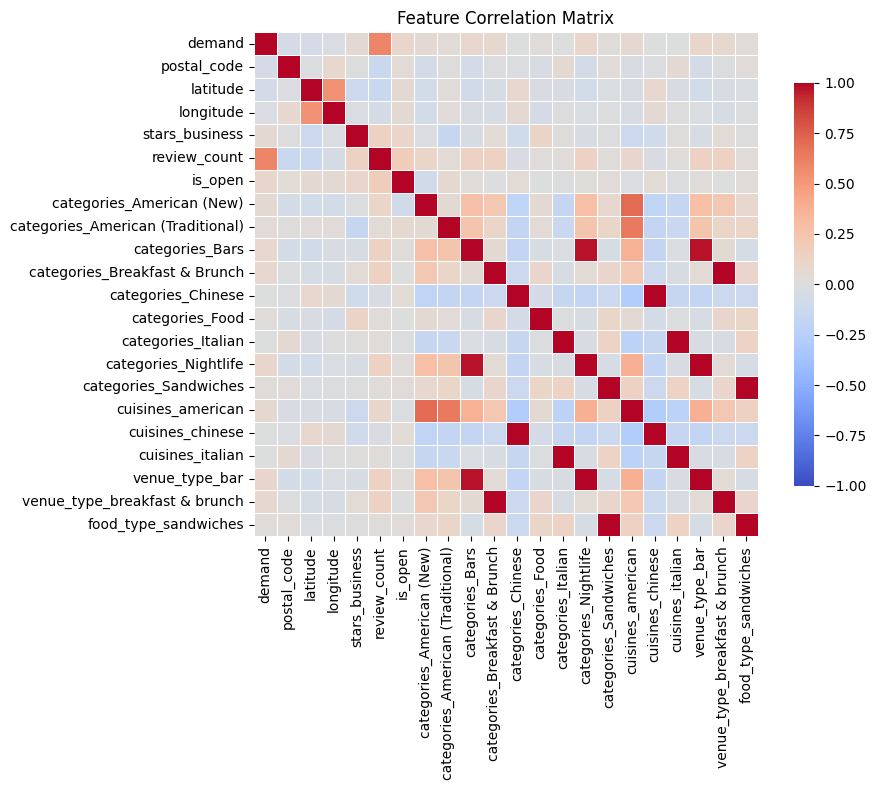

In [18]:
# Select only numeric columns (exclude identifiers)
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Remove non-feature columns
exclude_cols = ['business_id']  # Keep month if it's numeric timestamp, or remove it
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Analyzing correlations for {len(feature_cols)} numeric features")

# Calculate correlation matrix
corr_matrix = train_df[feature_cols].corr()

print(f"Correlation matrix shape: {corr_matrix.shape}")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [19]:
train_df.drop(columns=['food_type_sandwiches','venue_type_breakfast & brunch','venue_type_bar','cuisines_italian','cuisines_chinese','categories_Nightlife'],inplace=True)
test_df.drop(columns=['food_type_sandwiches','venue_type_breakfast & brunch','venue_type_bar','cuisines_italian','cuisines_chinese','categories_Nightlife'],inplace=True)
oot_df.drop(columns=['food_type_sandwiches','venue_type_breakfast & brunch','venue_type_bar','cuisines_italian','cuisines_chinese','categories_Nightlife'],inplace=True)

In [20]:
# import pandas as pd

# train_df = pd.read_csv('/content/drive/MyDrive/df_train.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/df_test.csv')
# oot_df = pd.read_csv('/content/drive/MyDrive/df_oot.csv')

In [21]:
# import numpy as np

# Apply same to test and oot
for df in [train_df, test_df, oot_df]:
    df['month_num'] = pd.to_datetime(df['month']).dt.month
    df['year'] = pd.to_datetime(df['month']).dt.year
    df['quarter'] = pd.to_datetime(df['month']).dt.quarter
    df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

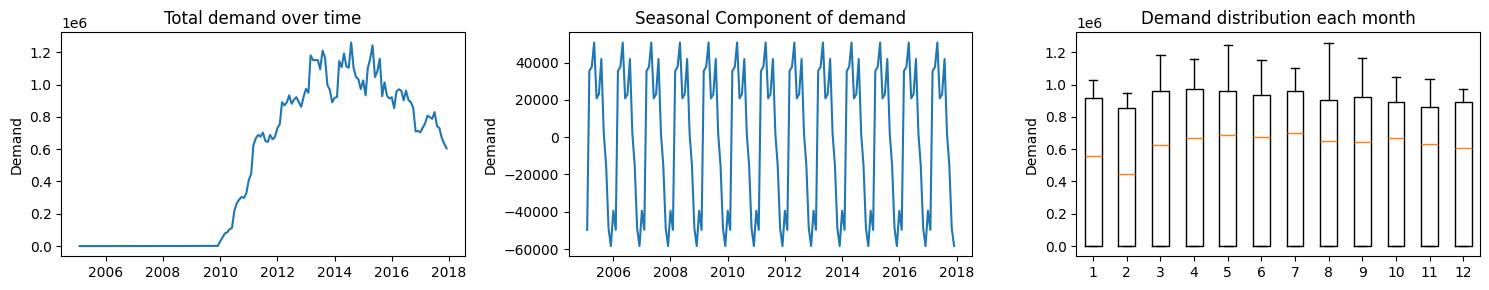

In [22]:
# Checking seasonality
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

monthly_demand = train_df.groupby('month')['demand'].sum().sort_index()

# Visual inspection
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# 1. Time series plot
axes[0].plot(pd.to_datetime(monthly_demand.reset_index()['month']), monthly_demand.reset_index()['demand'])
axes[0].set_title('Total demand over time')
axes[0].set_ylabel('Demand')

# 2. Seasonal decomposition
decomposition = seasonal_decompose(monthly_demand, model='additive', period=12)
axes[1].plot(pd.to_datetime(decomposition.seasonal.reset_index()['month']),decomposition.seasonal.reset_index()['seasonal'])
axes[1].set_title('Seasonal Component of demand')
axes[1].set_ylabel('Demand')

# 3. Box plot by month
monthly_data = train_df.groupby(['year', 'month_num'])['demand'].sum().reset_index()
axes[2].boxplot([monthly_data[monthly_data['month_num']==i]['demand'].values for i in range(1, 13)])
axes[2].set_title('Demand distribution each month')
axes[2].set_ylabel('Demand')
plt.tight_layout()
plt.show()

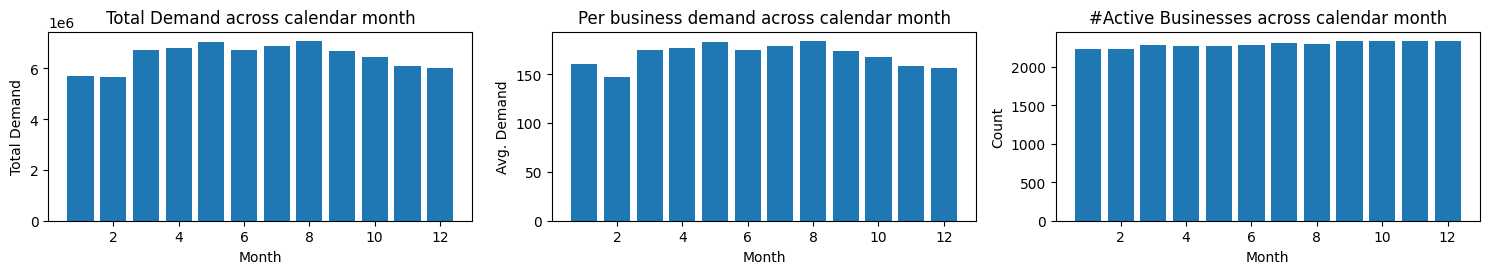

In [23]:
# Check what's driving the seasonality
# 1. Total demand by month (what seasonal decomposition used)
monthly_total = train_df.groupby('month_num')['demand'].sum().sort_index()

# 2. Average demand per business by month
monthly_avg = train_df.groupby('month_num')['demand'].mean().sort_index()

# 3. Number of active businesses by month
businesses_per_month = train_df[train_df['demand']>0].groupby('month_num')['business_id'].nunique().sort_index()

# 4. Visualize the breakdown
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# Total demand by month
axes[0].bar(monthly_total.index, monthly_total.values)
axes[0].set_title('Total Demand across calendar month')
axes[0].set_ylabel('Total Demand')
axes[0].set_xlabel('Month')

# Average demand by month
axes[1].bar(monthly_avg.index, monthly_avg.values)
axes[1].set_title('Per business demand across calendar month')
axes[1].set_ylabel('Avg. Demand')
axes[1].set_xlabel('Month')

# Active businesses by month
axes[2].bar(businesses_per_month.index, businesses_per_month.values)
axes[2].set_title('#Active Businesses across calendar month')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('Month')

plt.tight_layout()
plt.show()

In [24]:
from statsmodels.tsa.stattools import adfuller, kpss

# Augmented Dickey-Fuller Test (null hypothesis: non-stationary)
adf_result = adfuller(monthly_demand, autolag='AIC')

if adf_result[1] < 0.05:
    print(f"ADF - Series is STATIONARY (p < 0.05)")
else:
    print(f"ADF - Series is NON-STATIONARY (p >= 0.05)")

ADF - Series is NON-STATIONARY (p >= 0.05)


P-Value after one difference = 0.7118020684864329
P-Value after two differences = 5.243279519257568e-13


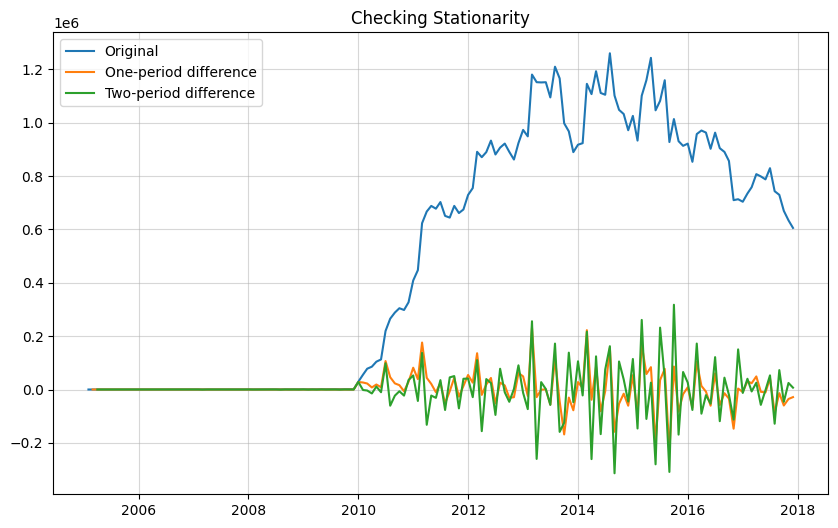

In [25]:
# Apply differencing
monthly_demand = train_df.groupby('month')['demand'].sum().sort_index()
monthly_demand_diff = monthly_demand.diff().dropna()
monthly_demand_diff2 = monthly_demand.diff().diff().dropna()

adf_diff = adfuller(monthly_demand_diff, autolag='AIC')
adf_diff2 = adfuller(monthly_demand_diff2, autolag='AIC')

print(f"P-Value after one difference = {adf_diff[1]}")
print(f"P-Value after two differences = {adf_diff2[1]}")

# Visualize all three
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.plot(pd.to_datetime(monthly_demand.reset_index()['month']),monthly_demand.values)
axes.plot(pd.to_datetime(monthly_demand_diff.reset_index()['month']),monthly_demand_diff.values)
axes.plot(pd.to_datetime(monthly_demand_diff2.reset_index()['month']),monthly_demand_diff2.values)
axes.set_title('Checking Stationarity')
axes.grid(alpha=0.5)
axes.legend(['Original','One-period difference','Two-period difference'])

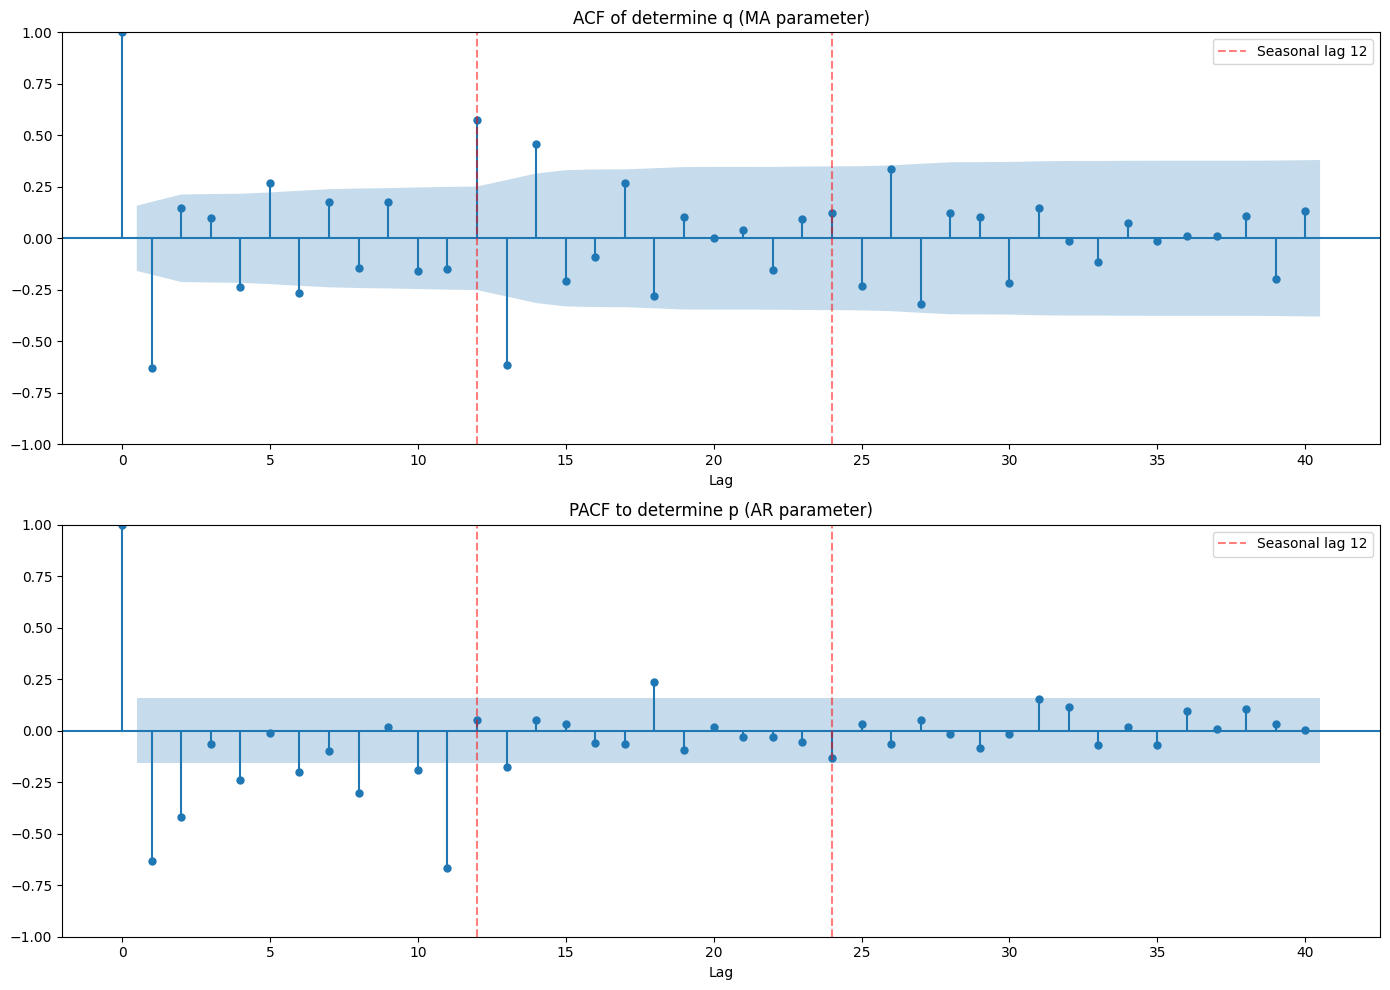

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Use second-differenced series for ACF/PACF
monthly_demand = train_df.groupby('month')['demand'].sum().sort_index()
monthly_demand_diff2 = monthly_demand.diff().diff().dropna()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ACF Plot - determines q (MA order)
plot_acf(monthly_demand_diff2, lags=40, ax=axes[0])
axes[0].set_title('ACF of determine q (MA parameter)')
axes[0].set_xlabel('Lag')
axes[0].axvline(x=12, color='red', linestyle='--', alpha=0.5, label='Seasonal lag 12')
axes[0].axvline(x=24, color='red', linestyle='--', alpha=0.5)
axes[0].legend()

# PACF Plot - determines p (AR order)
plot_pacf(monthly_demand_diff2, lags=40, ax=axes[1])
axes[1].set_title('PACF to determine p (AR parameter)')
axes[1].set_xlabel('Lag')
axes[1].axvline(x=12, color='red', linestyle='--', alpha=0.5, label='Seasonal lag 12')
axes[1].axvline(x=24, color='red', linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

all_cols = train_df.columns.tolist()
exog_feat = [col for col in all_cols if col not in ['business_id','month','demand']]

In [28]:
import sklearn.metrics as metric

# Aggregate demand but keep average business characteristics
monthly_aggregated_train = train_df.groupby('month').agg({
    'demand': 'mean',  # Total demand
    'stars_business': 'mean',  # Average rating
    'review_count': 'mean',  # Total reviews
    'latitude': 'mean',  # Geographic center
    'longitude': 'mean',
    # For binary features (categories, cuisines), use proportion
    **{col: 'mean' for col in exog_feat if col.startswith(('categories_', 'cuisines_', 'venue_type_','food_type_','fiet_features_'))}
}).reset_index()

monthly_aggregated_test = test_df.groupby('month').agg({
    'demand': 'mean',  # Total demand
    'stars_business': 'mean',  # Average rating
    'review_count': 'mean',  # Total reviews
    'latitude': 'mean',  # Geographic center
    'longitude': 'mean',
    # For binary features (categories, cuisines), use proportion
    **{col: 'mean' for col in exog_feat if col.startswith(('categories_', 'cuisines_', 'venue_type_','food_type_','fiet_features_'))}
}).reset_index()

monthly_aggregated_oot = oot_df.groupby('month').agg({
    'demand': 'mean',  # Total demand
    'stars_business': 'mean',  # Average rating
    'review_count': 'mean',  # Total reviews
    'latitude': 'mean',  # Geographic center
    'longitude': 'mean',
    # For binary features (categories, cuisines), use proportion
    **{col: 'mean' for col in exog_feat if col.startswith(('categories_', 'cuisines_', 'venue_type_','food_type_','fiet_features_'))}
}).reset_index()

y_train = monthly_aggregated_train['demand']
X_train = monthly_aggregated_train.drop(['demand','month'],axis = 1)

y_test = monthly_aggregated_test['demand']
X_test = monthly_aggregated_test.drop(['demand','month'],axis = 1)

y_oot = monthly_aggregated_oot['demand']
X_oot = monthly_aggregated_oot.drop(['demand','month'],axis = 1)

configs = [
    ((1, 2, 1), (1, 1, 1, 12), "A"),
    ((2, 2, 1), (1, 1, 1, 12), "B"),
    ((1, 2, 1), (0, 1, 1, 12), "C"),
    ((1, 2, 0), (1, 1, 1, 12), "D"),
    ((0, 2, 1), (1, 1, 1, 12), "E")
]

results_summary = []
fitted_models = {}

for order, seasonal_order, name in configs:

  model = SARIMAX(
      endog=y_train,
      exog=X_train,
      order=order,
      seasonal_order=seasonal_order,
      enforce_stationarity = False,
      enforce_invertibility = False
  )

  fitted = model.fit(disp=True, maxiter = 100)
  fitted_models[name] = fitted
  test_forecast = fitted.forecast(steps = len(y_test), exog = X_test)
  oot_forecast = fitted.forecast(steps = len(y_oot), exog = X_oot)

  test_mae = metric.mean_absolute_error(y_test, test_forecast)
  test_rmse = np.sqrt(mean_squared_error(y_test, test_forecast))
  test_mape = metric.mean_absolute_percentage_error(y_test, test_forecast)
  test_rsq = 1-(np.sum((y_test-test_forecast)**2)/np.sum((y_test-np.mean(y_test))**2))

  oot_mae = metric.mean_absolute_error(y_oot, oot_forecast)
  oot_rmse = np.sqrt(mean_squared_error(y_oot, oot_forecast))
  oot_mape = metric.mean_absolute_error(y_oot,oot_forecast)

  results_summary.append({
      'Scenario': name,
      'Order': f"{order}{seasonal_order}",
      'Test_MAE': round(test_mae, 0),
      'Test_RMSE': round(test_rmse, 0),
      'Test_MAPE': test_mape,
      'OOT_MAE': round(oot_mae, 0),
      'OOT_RMSE': round(oot_rmse, 0),
      'OOT_MAPE': oot_mape,
      'Test_R²': round(test_rsq, 4)
  })

In [29]:
results_df = pd.DataFrame(results_summary)
results_df

,Scenario,Order,Test_MAE,Test_RMSE,Test_MAPE,OOT_MAE,OOT_RMSE,OOT_MAPE,Test_R²
0,A,"(1, 2, 1)(1, 1, 1, 12)",14.0,16.0,0.078764,151.0,155.0,150.618098,1.0
1,B,"(2, 2, 1)(1, 1, 1, 12)",13.0,16.0,0.077585,151.0,156.0,151.441982,1.0
2,C,"(1, 2, 1)(0, 1, 1, 12)",22.0,29.0,0.142654,135.0,143.0,134.923949,1.0
3,D,"(1, 2, 0)(1, 1, 1, 12)",81.0,90.0,0.508048,212.0,212.0,211.673356,1.0
4,E,"(0, 2, 1)(1, 1, 1, 12)",13.0,15.0,0.074985,148.0,153.0,147.684074,1.0


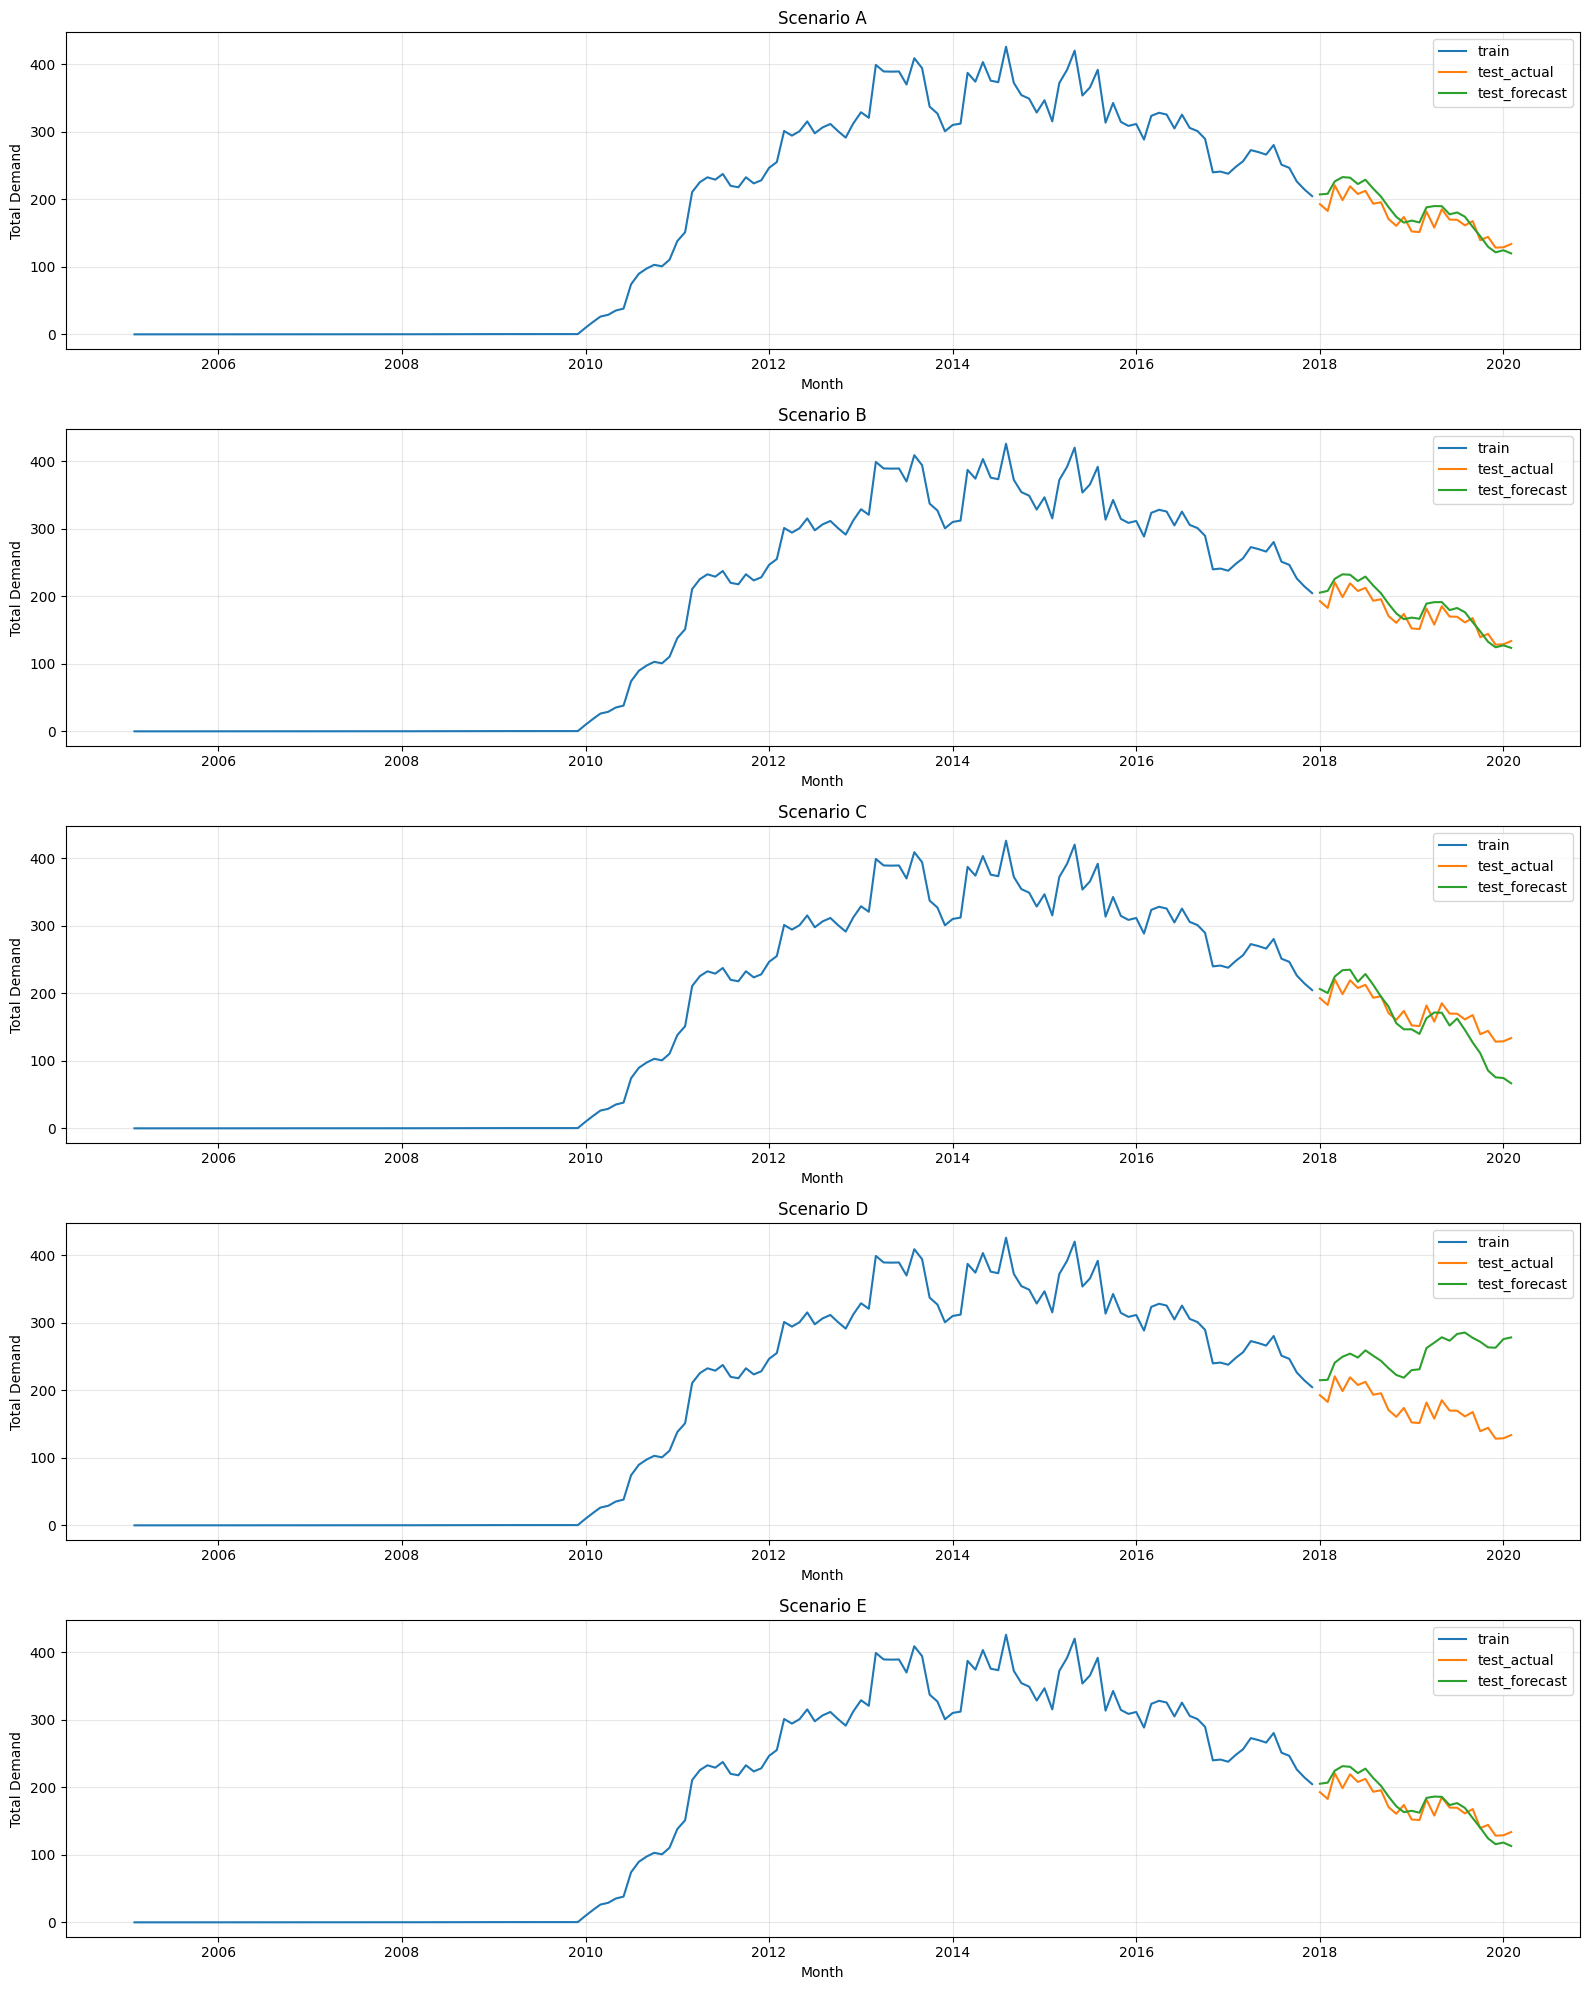

In [30]:
best_model = fitted_models['E']
test_forecasts = {}
oot_forecasts = {}

for name, fitted in fitted_models.items():
  test_forecasts[name] = fitted.forecast(steps=len(y_test),exog=X_test)
  oot_forecasts[name] = fitted.forecast(steps=len(y_oot),exog=X_oot)
fig, axes = plt.subplots(5,1,figsize = (16,20))

for idx, (model_name, forecast) in enumerate(test_forecasts.items()):
  ax = axes[idx]
  model_stats = results_df[results_df['Scenario'] == model_name].iloc[0]

  ax.plot(pd.to_datetime(monthly_aggregated_train['month']),y_train)
  ax.plot(pd.to_datetime(monthly_aggregated_test['month']),y_test)
  ax.plot(pd.to_datetime(monthly_aggregated_test['month']),forecast)
  ax.set_title(f"Scenario {model_name}")
  ax.set_xlabel('Month')
  ax.set_ylabel('Total Demand')
  ax.legend(['train','test_actual','test_forecast'],loc='upper right')
  ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-4057280095.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


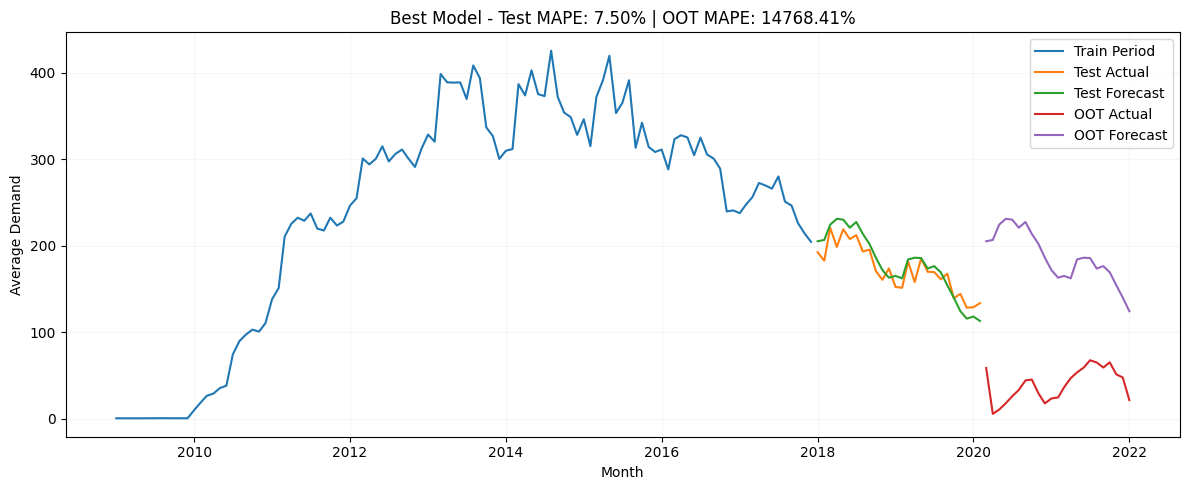

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))

best_test_forecast = test_forecasts['E']
best_oot_forecast = oot_forecasts['E']

ax.plot(pd.to_datetime(monthly_aggregated_train[pd.to_datetime(monthly_aggregated_train['month']).dt.year>2008]['month']), monthly_aggregated_train[pd.to_datetime(monthly_aggregated_train['month']).dt.year>2008]['demand'])
ax.plot(pd.to_datetime(monthly_aggregated_test['month']), y_test)
ax.plot(pd.to_datetime(monthly_aggregated_test['month']), best_test_forecast)
ax.plot(pd.to_datetime(monthly_aggregated_oot['month']), y_oot)
ax.plot(pd.to_datetime(monthly_aggregated_oot['month']), best_oot_forecast)

best_stats = results_df[results_df['Scenario'] == 'E'].iloc[0]
ax.set_title(f'Best Model - ' + f'Test MAPE: {best_stats["Test_MAPE"]*100:.2f}% | OOT MAPE: {best_stats["OOT_MAPE"]*100:.2f}%')
ax.set_xlabel('Month',fontsize=10)
ax.set_ylabel('Average Demand',fontsize=10)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.1)
plt.legend(['Train Period','Test Actual','Test Forecast','OOT Actual','OOT Forecast'])

plt.tight_layout()
plt.show()